In [1]:
import pandas as pd
import seaborn as sns

pd.__version__

'1.5.3'

# extract and cleanup
Note: If you've already run this before and saved the result in a `parquet` file, then you can go directly to the `parquet` section and load the data.

[CDC website](https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm)&mdash;see *Mortality Multiple Cause Files* for data and [User's Guide](https://www.cdc.gov/nchs/nvss/mortality_public_use_data.htm).

[2021 data](https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/DVS/mortality/mort2021us.zip)

### fixed-width pandas reader

In [ ]:
df = pd.read_fwf(
    "../data/mort2021us.txt",  # local download of 2021 data from CDC site
    colspecs = [
        (68, 69),
        (69, 70),
        (70, 73),
        (106, 107),
        (145, 149),
        (488, 491),
    ],
    names = ["sex", "age_unit", "age", "manner", "cause", "race"],
)
df

In [ ]:
df.dtypes

### adjust series values

In [ ]:
mort = (df
 .assign(
     # categorize
     sex=df.sex.astype("category"),
     
     # if age is in years or unstated (999), keep it, else set it to zero
     age=(((df.age_unit == 1) | (df.age == 999)) * df.age).astype("int16"),
     
     # switch manner to categorical
     manner=df.manner.fillna(0).astype(int).map({
         0: "Unspecified",
         1: "Accident",
         2: "Suicide",
         3: "Homicide",
         4: "Pending",
         5: "Unknown",
         6: "Self-inflicted",
         7: "Natural",
     }).astype("category"),
     
     # right-size
     race=df.race.astype("int8"),
     
     # gun-related causes
     gun=df.cause.isin({
        "W33", "W330", "W331", "W34", "W340", "W341", "X72", "X72X", "X73", "X730", "X731", "X732", "X738",
        "X739", "X748", "X749", "X93", "X93X", "X94", "X940", "X941", "X942", "X948", "X949", "X95", "X958",
        "X959", "Y22", "Y22X", "Y23", "Y230", "Y231", "Y232", "Y233", "Y238", "Y239", "Y24", "Y249", "Y350",
        "Y384"
     }),
 )
        
 .drop(columns=["age_unit"])
)
mort

# parquet

If the dataset or cleanup changes, re-run the `mort.to_parquet`; otherwise, you can start here by directly loading the prepared data from the `parquet` file using `pd.read_parquet`.

Note: this works because we've `pip` installed `pyarrow`.

In [ ]:
mort.to_parquet("../data/mort2021us.parquet")

In [2]:
mort = pd.read_parquet("../data/mort2021us.parquet")

# view

In [3]:
sns.set_theme()

In [4]:
mort = mort.assign(deaths=1)  # accumulator for grouped counts

### Global view of the data

`Natural` is the most common manner of death.

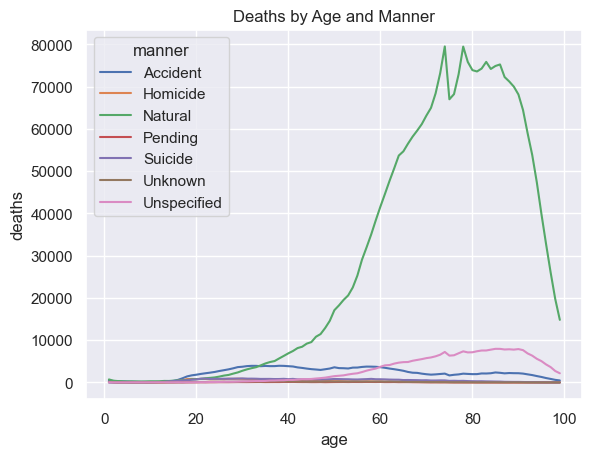

In [5]:
data = (mort
 .query("100 > age > 0")
 [["age", "manner", "deaths"]].groupby(["age", "manner"])
 .count()
)
ax = sns.lineplot(data, x="age", y="deaths", hue="manner")
_ = ax.set_title("Deaths by Age and Manner")

If `natural` and `unspecified` are removed, then `accident` prevails with `suicide` and `homicide` starting to show.

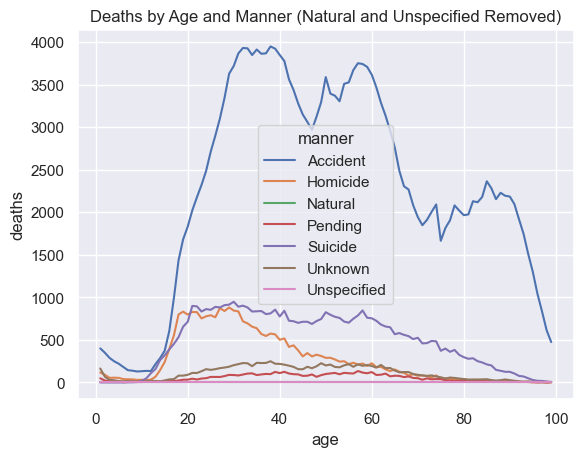

In [26]:
data = (mort
 .query("100 > age > 0")
 .query("manner != 'Natural'").query("manner != 'Unspecified'")
 [["age", "manner", "deaths"]].groupby(["age", "manner"])
 .count()
)
ax = sns.lineplot(data, x="age", y="deaths", hue="manner")
_ = ax.set_title("Deaths by Age and Manner (Natural and Unspecified Removed)")

Without `accident`, a clear spike in `homicide`, and a more sustained `suicide` are evident.

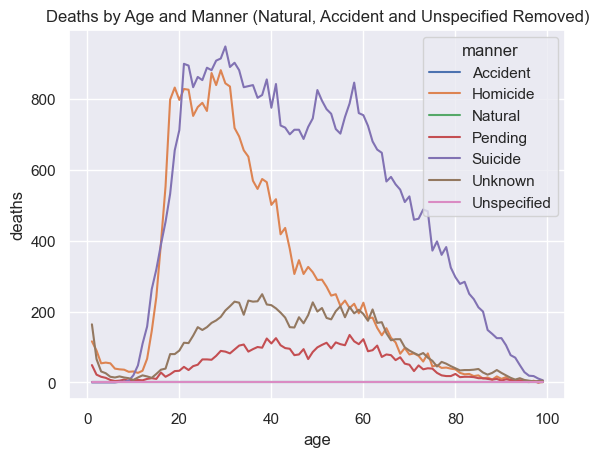

In [7]:
data = (mort
 .query("100 > age > 0")
 .query("manner != 'Natural'").query("manner != 'Unspecified'")
 .query("manner != 'Accident'")
 [["age", "manner", "deaths"]].groupby(["age", "manner"])
 .count()
)
ax = sns.lineplot(data, x="age", y="deaths", hue="manner")
_ = ax.set_title("Deaths by Age and Manner (Natural, Accident and Unspecified Removed)")

### View by Sex

We can run through the same graphs broken out by sex.

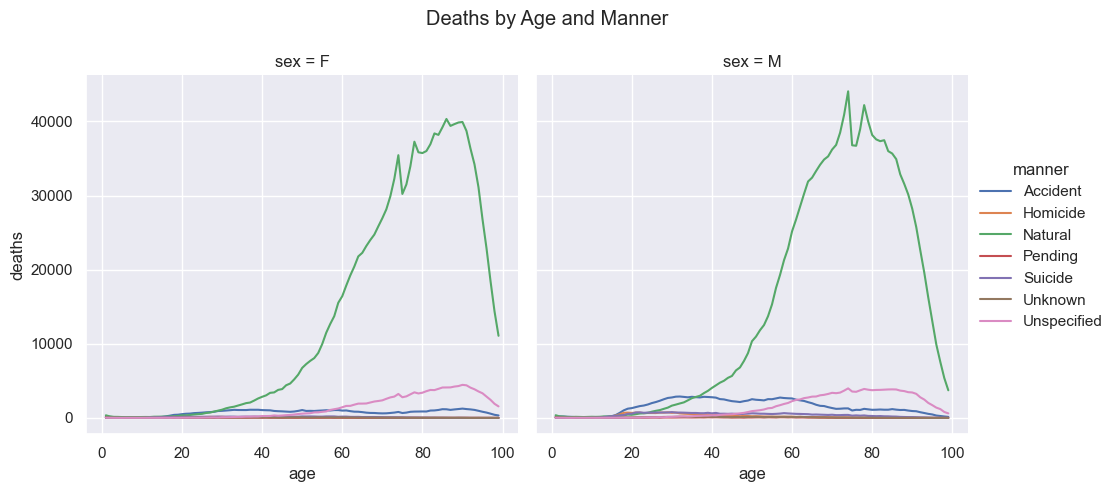

In [8]:
data = (mort
 .query("100 > age > 0")
 [["age", "manner", "sex", "deaths"]].groupby(["age", "manner", "sex"])
 .count()
)
rel = sns.relplot(data, kind="line", x="age", y="deaths", hue="manner", col="sex")
rel.fig.subplots_adjust(top=.85)
_ = rel.fig.suptitle("Deaths by Age and Manner")

This is the "it sucks to be a man" slide: more accidents, suicides and homicides.

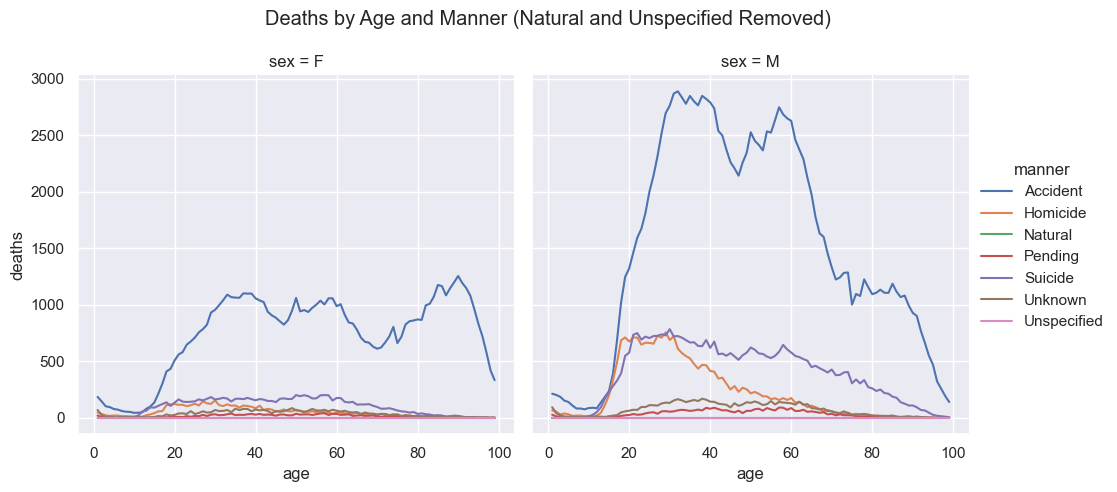

In [9]:
data = (mort
 .query("100 > age > 0")
 .query("manner != 'Natural'").query("manner != 'Unspecified'")
 [["age", "manner", "sex", "deaths"]].groupby(["age", "manner", "sex"])
 .count()
)
rel = sns.relplot(data, kind="line", x="age", y="deaths", hue="manner", col="sex")
rel.fig.subplots_adjust(top=.85)
_ = rel.fig.suptitle("Deaths by Age and Manner (Natural and Unspecified Removed)")

We start to see that the combined spike in `homicide` and the longer trend in `suicide` is a male thing.

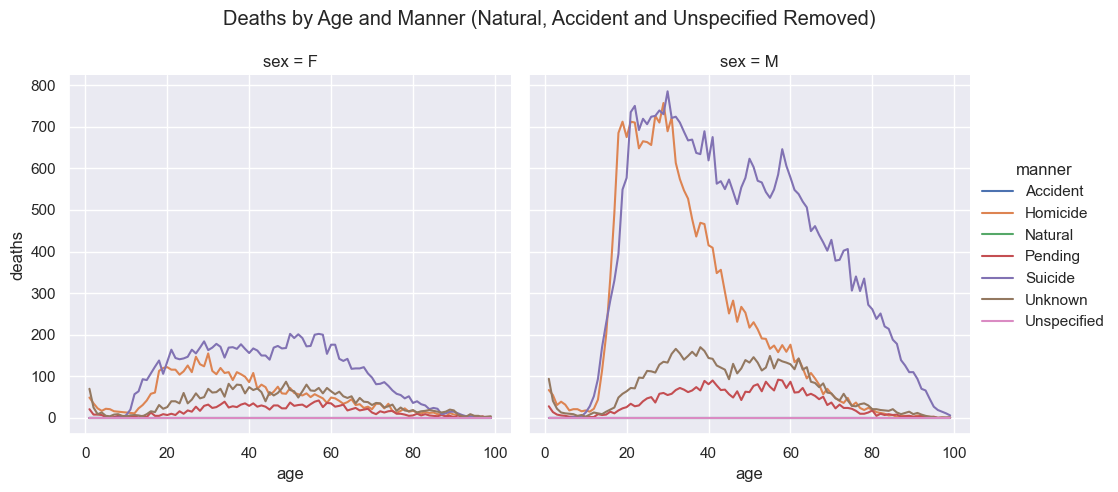

In [10]:
data = (mort
 .query("100 > age > 0")
 .query("manner != 'Natural'").query("manner != 'Unspecified'")
 .query("manner != 'Accident'")
 [["age", "manner", "sex", "deaths"]].groupby(["age", "manner", "sex"])
 .count()
)
rel = sns.relplot(data, kind="line", x="age", y="deaths", hue="manner", col="sex")
rel.fig.subplots_adjust(top=.85)
_ = rel.fig.suptitle("Deaths by Age and Manner (Natural, Accident and Unspecified Removed)")

This next graph focuses on the male numbers by race&mdash;broken down by `white` (1), `black` (2) and `other` (not 1 or 2). It is clear that `black` men are dying by homicide at a significantly higher rate than the rest of the population.

The variable `r` contains a normalized value for each race to account for differences in population size&mdash;just counting the number of deaths would not make it possible to compare these categories; using the values in `r` normalizes the counts.

**Note** that the numbers in `scaled_deaths` are not counts; the values should be ignored except for comparison purposes.

In [36]:
r = 1 / (mort
 .assign(race=mort.race.apply(lambda x: x if x in (1,2) else 3))
 ["race"]
 .value_counts(normalize=True)
)
r[1],r[2],r[3]

(1.2117383796490826, 7.58883570476253, 23.273765634845095)

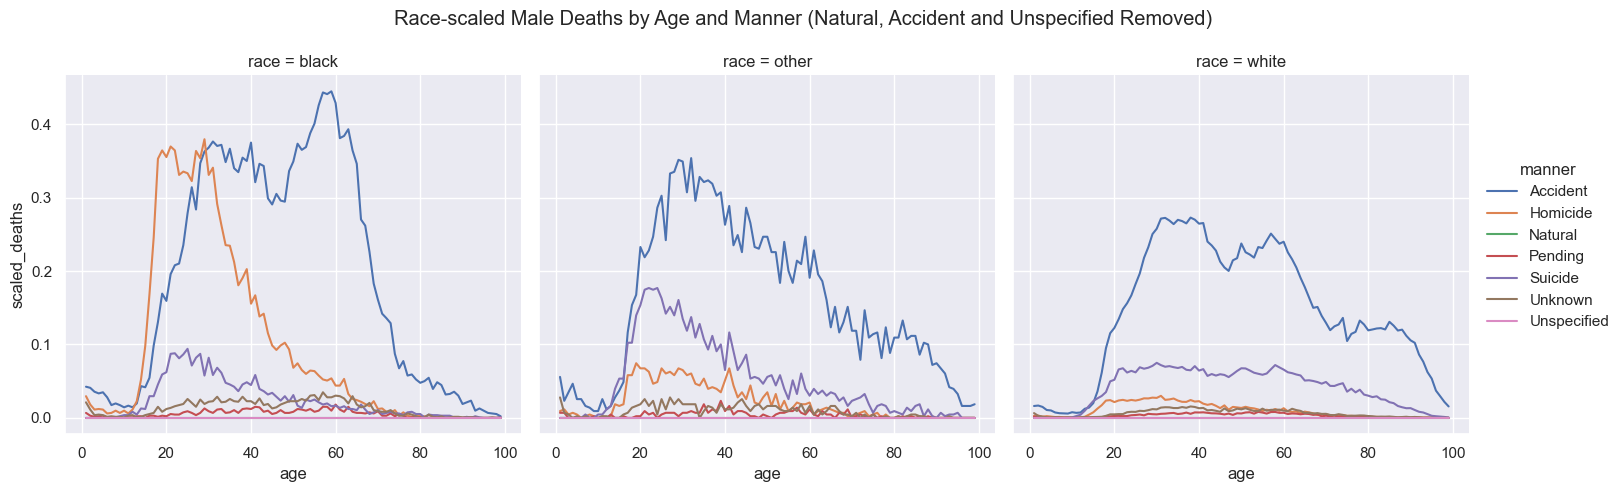

In [45]:
data = (mort
 .assign(
     race=mort.race.apply(lambda x: {1: "white", 2: "black", 3: "other"}[x if x in (1,2) else 3]),
     scaled_deaths=mort.race.apply(lambda x: r[x if x in (1,2) else 3])
 )
 .query("100 > age > 0")
 .query("manner != 'Natural'").query("manner != 'Unspecified'")
 #.query("manner != 'Accident'")
 .query("sex == 'M'")
 [["age", "manner", "race", "scaled_deaths"]].groupby(["age", "manner", "race"])
 .sum() / 10000  # make sum(scaled_deaths) meaningless
)
rel = sns.relplot(data, kind="line", x="age", y="scaled_deaths", hue="manner", col="race")
rel.fig.subplots_adjust(top=.85)
_ = rel.fig.suptitle("Race-scaled Male Deaths by Age and Manner (Natural, Accident and Unspecified Removed)")

In [ ]:
data = (mort
 .query("100 > age > 0")
 #.query("gun")
 .query("manner != 'Natural'").query("manner != 'Unspecified'")
 #.query("manner != 'Accident'")
 #[["age", "manner", "deaths"]].groupby(["age", "manner"])
 [["age", "manner", "sex", "deaths"]].groupby(["age", "manner", "sex"])
 .count()
)
sns.relplot(data, kind="line", x="age", y="deaths", hue="manner", col="sex")
#sns.relplot(data, kind="line", x="age", y="deaths", hue="manner")

In [ ]:
mort.race.value_counts()

In [ ]:
mort.race.apply(lambda x: (x if x in (1,2) else 3)).value_counts()